### Summary

In this project, I wanted to train a classifier model to receive sentences as inputs and be able to correctly output a sentiment (positive, negative, or neutral) that is expressed in the sentence. To achieve that, I used a labeled data set of sentences, cleaned it, used the Doc2Vec algorithm to vectorize the sentences, and then trained and tested different classification models. 

Throughout the project, I saw that with default parameters for support vector classifier and logistic regression the size of the output vector from Doc2Vec didn’t present a big impact on classification performance. Furthermore, I saw that SVC performance increased from about 62% accuracy to 72% when we balanced the dataset by oversampling the smaller classes. In addition to that, when searching for the best parameters, I found out that the best ones were the default.

To conclude, this project was great to learn more about NLP algorithms, such as Doc2Vec and Word2Vec, especially the particularities related to coding it in Python. It was also interesting to review some of the most common classifiers available on sklearn package and how to optimize them to achieve the best results.

### Importing packages, loading data and creating functions

In [9]:
import pandas as pd               # Library for reading files 
import string                     # working with strings
import re                         # regular expressions
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk                       # Natural Language Toolkit
from nltk.corpus import stopwords # stop words
from nltk.stem.porter import PorterStemmer # PoterStemmer
from nltk.corpus import wordnet            # Wordnet
from nltk.stem import WordNetLemmatizer    # lemmatizer
from nltk.tokenize import word_tokenize

from collections import Counter            # 

import gensim #vectorization package
from gensim.models.doc2vec import Doc2Vec, TaggedDocument #vectorization neural net 
from gensim.models import Word2Vec #vectorization neural net
from gensim.models.phrases import Phrases, Phraser #phraser do collect bigrams

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

In [2]:
data = pd.read_csv('unprocessed data.csv', sep=';', encoding='latin-1',header =0)
#print(data.shape)
#print("COLUMN NAMES" , data.columns)
#print(data.info())

In [3]:
stopword = nltk.corpus.stopwords.words('english')
STOPWORDS = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

def brief_cleaning(text):
    """makes all text lower case and removes punctuation"""
    
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text).lower()
    return text

def remove_stopwords(text, STOPWORDS):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def stem_words(text, stemmer):
    return " ".join([stemmer.stem(word) for word in text.split()])

def lemmatize_words(text, lemmatizer, wordnet_map ):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

In [4]:
def tag_docs(x):
    """this function takes a list of lists (each word in an element on the inside list) and returns a tagged document, 
    that is necessary for the doc2vec model"""
    
    return [TaggedDocument(words=_d, tags=[str(i)]) for i, _d in enumerate(x)]

In [5]:
def train_doc2vec_model(tagged_docs, vector_size, min_count):
    """this functions tkaes the tagged documents, vector_size and min_count and returns the model trained.
    The model can be used to predict the vectors of the documents on the training and testing set
    
    vector_size =  Dimensionality of the feature vectors.
    min_count =  Ignores all words with total frequency lower than this.
    """
    
    doc2vec_model = Doc2Vec(vector_size=vector_size, min_count=min_count, epochs=40)
    doc2vec_model.build_vocab(tagged_docs)
    doc2vec_model.train(tagged_docs, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
    
    return doc2vec_model

In [6]:
def infer_vectors(doc2vec_model, docs):
    """this function takes the model and a list of documents (where each document is a list of words) and
    returns the predicted vector for it"""
    
    vectors = []
    for vec in docs:
        vectors.append(doc2vec_model.infer_vector(vec))
        
    return vectors

### Pre-processing the data

In [92]:
#remove punctuation and make all lower case
data['Sentence'] = data['Sentence'].apply(lambda text: brief_cleaning(text))

#remove first set of stopwords
data['Sentence'] = data['Sentence'].apply(lambda text: remove_stopwords(text, STOPWORDS))

#remove second set of stopwords
data['Sentence'] = data['Sentence'].apply(lambda text: remove_stopwords(text, stopword))

#applying lemmatize
data['Sentence'] = data['Sentence'].apply(lambda text: lemmatize_words(text, lemmatizer, wordnet_map))

#selecting the words in the sentences
sents = [row.split(' ') for row in data['Sentence']]

#select bigram
phrases = Phrases(sents, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sents]

#set x as a list of documents, where each document is a list of words
x = sentences

#Convert sting to numeric
sentiment  = {'positive': 0,'neutral': 1,'negative':2} 
y = [sentiment[item] for item in data.Sentiment] 
#y = data.Sentiment

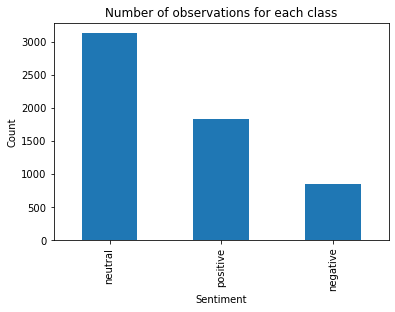

In [20]:
#here we plot the data and we can see that the data is unbalanced... later in the analysis we will try to balance it
data.Sentiment.value_counts().plot(kind = 'bar')
plt.title('Number of observations for each class')
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.show()

### Doc2Vec

In [93]:
#first we divide the data into training and testing - usage of stratify to keep the balance.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)

In [94]:
#2nd we have to set x_train as a tagged doc, bc it will be used to train the doc2vec
x_train_tagged = tag_docs(x_train)

`X = df_new['essay_content']`

`y = df_new['label']`

`X_train, X_test, y_train, y_test = train_test_split(X, y)`

`vectorizer = TfidfVectorizer(stop_words='english')`

`X_train_dtm = vectorizer.fit_transform(X_train)`

`X_test_dtm = vectorizer.transform(X_test)`

`clf_lr = LogisticRegression()`

`clf_lr.fit(X_train_dtm, y_train)`

`y_pred = clf_lr.predict(X_test_dtm)`


"In the code example above we would split the document set into training and testing, and then use ONLY training documents to build the term collection. This way, we are making sure that the classifier trained on the training tf-idf matrix is generalizing well.

Therefore, I feel that doc2vec workflow should follow the same general principal, i.e. to train (build vocabulary) the doc2vec ONLY using training documents"

- source: https://fzr72725.github.io/2018/01/14/genism-guide.html

In [95]:
#now we will train the doc2vec on the training data
doc2vec_model = train_doc2vec_model(x_train_tagged, vector_size = 50, min_count = 1)

In [96]:
#here we will infer the vector values for for x_train and x_test.
#we have to use the un-tagged x_train
x_train_vectors = infer_vectors(doc2vec_model, x_train)
x_test_vectors = infer_vectors(doc2vec_model, x_test)

"This is one of the most confusing parts for me in the doc2vec training process. Many code examples did not use infer_vector() to “retrain” the document vectors. Instead, they used the trained vectors from the doc2vec_model directly as the final vector matrix. I think this is also one of the motivations for people to assign a unique tag to each document as I mentioned earlier.

I personally found it more reasonable to use infer_vector() to “retrain” the document vector. Reason being: “You could certainly use the vectors learned during training. But note that during much of their 20-training-passes, the model itself was still undergoing rapid change, and was far from its final state. I’ve sometimes seen that re-inferred vectors, often work better for downstream tasks. This is perhaps because then all 20-inference-passes, across all re-inferred vectors, equally benefit from the same final frozen model state”, quoted Gordon Mohr from a Google group Q&A."

- source: https://fzr72725.github.io/2018/01/14/genism-guide.html

In [97]:
#now that we have both x_train and x_test vectorized we can train our classification model

lr_not_os = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr_not_os.fit(x_train_vectors, y_train)

y_pred_not_os = lr_not_os.predict(x_test_vectors)

print ('Test Accuracy: %.5f'%lr_not_os.score(x_test_vectors, y_test))

Test Accuracy: 0.62069


In [116]:
from sklearn.metrics import recall_score

recall_score(y_test, y_pred_not_os, average = 'macro')

0.46827017963036405

In [129]:
confusion_matrix(y_test, y_pred_not_os)

array([[163, 191,  12],
       [ 72, 541,  13],
       [ 57,  95,  16]], dtype=int64)

### Trying to optimize the vector_size

In [27]:
#Now I'll try to optimize the vector size, doing a loop between 50 and 300
vect_sizes = np.arange(10, 350, 40)
models = []
scores = []
conf_matrixes = []

import time
start = time.time()

for vec in vect_sizes:
    #initiate and train the model
    model = train_doc2vec_model(x_train_tagged, vector_size = vec, min_count = 1)
    #predict training vectors
    x_train_vectors = infer_vectors(doc2vec_model, x_train)
    #predict testing vectors
    x_test_vectors = infer_vectors(doc2vec_model, x_test)
    #initiate classification model
    lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
    #fit training values
    lr.fit(x_train_vectors, y_train)
    
    models.append(model)
    scores.append(lr.score(x_test_vectors, y_test))
    conf_matrixes.append(confusion_matrix(y_test, lr.predict(x_test_vectors)))
    
    #print score, vector size and how long it took
    print ('Test Accuracy: %.5f'%lr.score(x_test_vectors, y_test))
    print('Vector size: ' + str(vec))
    print(confusion_matrix(y_test, lr.predict(x_test_vectors)))
    print('time: ' + str(time.time()-start))
    print('\n')

Test Accuracy: 0.59138
Vector size: 10
[[145 203  18]
 [ 90 518  18]
 [ 48  97  23]]
time: 22.619375228881836


Test Accuracy: 0.59310
Vector size: 50
[[152 197  17]
 [ 91 515  20]
 [ 56  91  21]]
time: 47.930750131607056


Test Accuracy: 0.58966
Vector size: 90
[[147 204  15]
 [ 88 518  20]
 [ 49 100  19]]
time: 71.18521165847778


Test Accuracy: 0.59310
Vector size: 130
[[153 198  15]
 [ 92 514  20]
 [ 53  94  21]]
time: 93.72764587402344


Test Accuracy: 0.60000
Vector size: 170
[[157 193  16]
 [ 87 520  19]
 [ 55  94  19]]
time: 116.14655804634094


Test Accuracy: 0.59914
Vector size: 210
[[154 193  19]
 [ 89 518  19]
 [ 51  94  23]]
time: 138.5702829360962


Test Accuracy: 0.59052
Vector size: 250
[[150 199  17]
 [ 89 515  22]
 [ 53  95  20]]
time: 161.23874926567078


Test Accuracy: 0.58966
Vector size: 290
[[145 204  17]
 [ 87 520  19]
 [ 55  94  19]]
time: 183.96789002418518


Test Accuracy: 0.58879
Vector size: 330
[[146 202  18]
 [ 92 517  17]
 [ 49  99  20]]
time: 207.439585

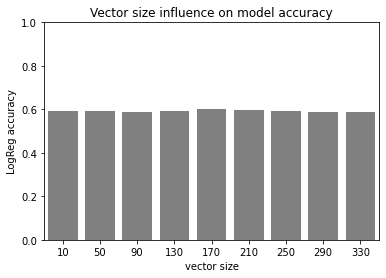

In [47]:
sns.barplot(x = vect_sizes, y = scores, color= 'gray')
plt.ylim(0,1)
plt.title('Vector size influence on model accuracy')
plt.xlabel('vector size')
plt.ylabel('LogReg accuracy')
plt.show()

Looks like the size doesnt influence as much, we can see that the model doesnt perform good on positive and negatives, so lets try to resample

### Testing Oversampling the data

In [109]:
#testing oversampling the data to get better accuracy
class_positive = data[data['Sentiment'] == 'positive']
class_negative = data[data['Sentiment'] == 'negative']
class_neutral = data[data['Sentiment'] == 'neutral']

class_count_neutral, class_count_positive, class_count_negative = data.Sentiment.value_counts()

class_positive_over = class_positive.sample(class_count_neutral, replace = True)
class_negative_over = class_negative.sample(class_count_neutral, replace = True)

data_oversampled = pd.concat([class_positive_over, class_negative_over, class_neutral], axis=0)

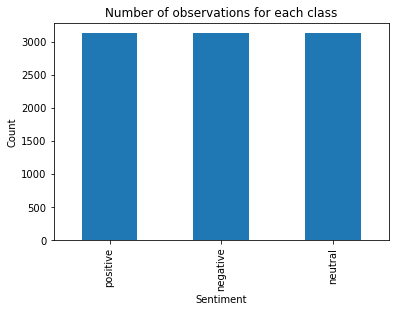

In [110]:
#now we can see that they all have the same amount of samples
data_oversampled.Sentiment.value_counts().plot(kind='bar')
plt.title('Number of observations for each class')
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.show()

In [111]:
#doing some pre-processing again

#selecting the words in the sentences
sents = [row.split(' ') for row in data['Sentence']]
sents_over = [row.split(' ') for row in data_oversampled['Sentence']]

#select bigram
phrases = Phrases(sents, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences_over = bigram[sents_over]

#set x as a list of documents, where each document is a list of words
x_over = sentences_over

#Convert sting to numeric
sentiment  = {'positive': 0,'neutral': 1,'negative':2} 
y_over = [sentiment[item] for item in data_oversampled.Sentiment] 

In [62]:
#first we divide the data into training and testing - usage of stratify to keep the balance.
x_train_over, x_test_over, y_train_over, y_test_over = train_test_split(x_over, y_over, test_size = 0.2, stratify = y_over)

#2nd we have to set x_train as a tagged doc, bc it will be used to train the doc2vec
x_train_tagged_over = tag_docs(x_train_over)

#now we will train the doc2vec on the training data
doc2vec_model = train_doc2vec_model(x_train_tagged_over, vector_size = 50, min_count = 1)

#here we will infer the vector values for for x_train and x_test.
#we have to use the un-tagged x_train
x_train_vectors_over = infer_vectors(doc2vec_model, x_train_over)
x_test_vectors_over = infer_vectors(doc2vec_model, x_test_over)

#now that we have both x_train and x_test vectorized we can train our classification model
lr_over = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr_over.fit(x_train_vectors_over, y_train_over)
print ('Test Accuracy: %.5f'%lr_over.score(x_test_vectors_over, y_test_over))

Test Accuracy: 0.56230


In [63]:
confusion_matrix(y_test_over, lr.predict(x_test_vectors_over))

array([[328, 161, 137],
       [101, 400, 125],
       [146, 152, 328]], dtype=int64)

Overall performance decreased, but the model predicts better positives and negatives (but this can happens bc we have the same data in training and testing - bc we oversampled with copies - so it can be overfitting)

In [63]:
#Now I'll try to optimize the vector size, doing a loop between 50 and 300
vect_sizes = np.arange(10, 350, 40)
models_os = []
scores_os = []
conf_matrixes_os = []

import time
start = time.time()

for vec in vect_sizes:
    #initiate and train the model
    model = train_doc2vec_model(x_train_tagged_over, vector_size = vec, min_count = 1)
    #predict training vectors
    x_train_vectors_over = infer_vectors(doc2vec_model, x_train_over)
    #predict testing vectors
    x_test_vectors_over = infer_vectors(doc2vec_model, x_test_over)
    #initiate classification model
    lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
    #fit training values
    lr.fit(x_train_vectors_over, y_train_over)
    
    models_os.append(model)
    scores_os.append(lr.score(x_test_vectors_over, y_test_over))
    conf_matrixes_os.append(confusion_matrix(y_test_over, lr.predict(x_test_vectors_over)))
    
    #print score, vector size and how long it took
    print ('Test Accuracy: %.5f'%lr.score(x_test_vectors_over, y_test_over))
    print('Vector size: ' + str(vec))
    print(confusion_matrix(y_test, lr.predict(x_test_vectors_over)))
    print('time: ' + str(time.time()-start))
    print('\n')

Test Accuracy: 0.56763
Vector size: 10
[[299 181 146]
 [103 408 115]
 [151 116 359]]
time: 37.60954976081848


Test Accuracy: 0.56443
Vector size: 50
[[303 173 150]
 [113 403 110]
 [144 128 354]]
time: 73.83449745178223


Test Accuracy: 0.56390
Vector size: 90
[[300 173 153]
 [108 404 114]
 [143 128 355]]
time: 110.89501166343689


Test Accuracy: 0.56390
Vector size: 130
[[298 173 155]
 [107 404 115]
 [147 122 357]]
time: 148.92317652702332


Test Accuracy: 0.56763
Vector size: 170
[[312 160 154]
 [110 400 116]
 [131 141 354]]
time: 186.30771350860596


Test Accuracy: 0.57135
Vector size: 210
[[296 178 152]
 [107 412 107]
 [137 124 365]]
time: 223.3817641735077


Test Accuracy: 0.57188
Vector size: 250
[[303 164 159]
 [106 414 106]
 [144 125 357]]
time: 263.93087458610535


Test Accuracy: 0.57029
Vector size: 290
[[301 179 146]
 [104 404 118]
 [142 118 366]]
time: 302.46192240715027


Test Accuracy: 0.56017
Vector size: 330
[[298 180 148]
 [108 400 118]
 [145 127 354]]
time: 339.082673

### Test scalling the vectors before classification model

In [64]:
#first we divide the data into training and testing - usage of stratify to keep the balance.
x_train_over, x_test_over, y_train_over, y_test_over = train_test_split(x_over, y_over, test_size = 0.2, stratify = y_over)

#2nd we have to set x_train as a tagged doc, bc it will be used to train the doc2vec
x_train_tagged_over = tag_docs(x_train_over)

#now we will train the doc2vec on the training data
doc2vec_model = train_doc2vec_model(x_train_tagged_over, vector_size = 50, min_count = 1)

#here we will infer the vector values for for x_train and x_test.
#we have to use the un-tagged x_train
x_train_vectors_over = infer_vectors(doc2vec_model, x_train_over)
x_test_vectors_over = infer_vectors(doc2vec_model, x_test_over)

x_train_vectors_over = scale(x_train_vectors_over)
x_test_vectors_over = scale(x_test_vectors_over)

#now that we have both x_train and x_test vectorized we can train our classification model
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr.fit(x_train_vectors_over, y_train_over)
print ('Test Accuracy: %.5f'%lr.score(x_test_vectors_over, y_test_over))

Test Accuracy: 0.58520


In [65]:
confusion_matrix(y_test, lr.predict(x_test_vectors))

array([[123,  80, 163],
       [255, 138, 233],
       [ 57,  35,  76]], dtype=int64)

### Testing different models

In [66]:
from sklearn.model_selection import GridSearchCV

In [67]:
#first we divide the data into training and testing - usage of stratify to keep the balance.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)

#2nd we have to set x_train as a tagged doc, bc it will be used to train the doc2vec
x_train_tagged = tag_docs(x_train)

#now we will train the doc2vec on the training data
doc2vec_model = train_doc2vec_model(x_train_tagged, vector_size = 50, min_count = 1)

#here we will infer the vector values for for x_train and x_test.
#we have to use the un-tagged x_train
x_train_vectors = infer_vectors(doc2vec_model, x_train)
x_test_vectors = infer_vectors(doc2vec_model, x_test)



In [68]:
#changing the parameters on the logistic regression

params_lr = {'solver':['newton-cg', 'sag', 'saga', 'lbfgs'],
         'class_weight':[None, 'balanced']}

lr = LogisticRegression(multi_class='multinomial')

gs_lr = GridSearchCV(lr, params_lr)

gs_lr.fit(x_train_vectors, y_train)

#print ('Test Accuracy: %.5f'%gs_lr.score(x_test_vectors, y_test))

GridSearchCV(estimator=LogisticRegression(multi_class='multinomial'),
             param_grid={'class_weight': [None, 'balanced'],
                         'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']})

In [69]:
#best estimator
best_lr = gs_lr.best_estimator_

gs_lr.best_params_

{'class_weight': None, 'solver': 'newton-cg'}

In [70]:
print ('Test Accuracy: %.5f'%best_lr.score(x_test_vectors, y_test))

Test Accuracy: 0.60172


In [130]:
#search params on SVC
from sklearn.svm import SVC

params_svc = {'class_weight':[None, 'balanced'],
             'decision_function_shape':['ovo', 'ovr']}

svc = SVC()

gs_svc = GridSearchCV(svc, params_svc)

gs_svc.fit(x_train_vectors, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'class_weight': [None, 'balanced'],
                         'decision_function_shape': ['ovo', 'ovr']})

In [131]:
#best estimator
best_svc = gs_svc.best_estimator_

gs_svc.best_params_

{'class_weight': None, 'decision_function_shape': 'ovo'}

In [132]:
print ('Test Accuracy: %.5f'%best_svc.score(x_test_vectors, y_test))

Test Accuracy: 0.64138


In [133]:
y_pred_svc = best_svc.predict(x_test_vectors)

In [134]:
confusion_matrix(y_test, y_pred_svc)

array([[167, 198,   1],
       [ 51, 571,   4],
       [ 56, 106,   6]], dtype=int64)

In [121]:
#trying naive bayes classifier
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(x_train_vectors, y_train)
gnb.score(x_test_vectors, y_test)

0.4706896551724138

In [122]:
#trying random forest class
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=20, random_state=0)

rfc.fit(x_train_vectors, y_train)
rfc.score(x_test_vectors, y_test)

0.5956896551724138

The best model was SVC without class_weight and oVo approach

In [123]:
confusion_matrix(y_test, best_svc.predict(x_test_vectors))

array([[165, 196,   5],
       [ 50, 564,  12],
       [ 57, 107,   4]], dtype=int64)

### Testing SVC with oversampled data

In [135]:
#first we divide the data into training and testing - usage of stratify to keep the balance.
x_train_over, x_test_over, y_train_over, y_test_over = train_test_split(x_over, y_over, test_size = 0.2, stratify = y_over)

#2nd we have to set x_train as a tagged doc, bc it will be used to train the doc2vec
x_train_tagged_over = tag_docs(x_train_over)

#now we will train the doc2vec on the training data
doc2vec_model = train_doc2vec_model(x_train_tagged_over, vector_size = 50, min_count = 1)

#here we will infer the vector values for for x_train and x_test.
#we have to use the un-tagged x_train
x_train_vectors_over = infer_vectors(doc2vec_model, x_train_over)
x_test_vectors_over = infer_vectors(doc2vec_model, x_test_over)

#now that we have both x_train and x_test vectorized we can train our classification model
svc = SVC()
svc.fit(x_train_vectors_over, y_train_over)
print ('Test Accuracy: %.5f'%svc.score(x_test_vectors_over, y_test_over))

Test Accuracy: 0.72684


In [136]:
confusion_matrix(y_test_over, svc.predict(x_test_vectors_over))

array([[395, 107, 124],
       [ 52, 443, 131],
       [ 46,  53, 527]], dtype=int64)

### Searching for the best params for SVC with oversampled data

In [128]:
#search params on SVC
params_svc = {'class_weight':[None, 'balanced'],
             'decision_function_shape':['ovo', 'ovr']}

svc = SVC()

gs_svc = GridSearchCV(svc, params_svc)

gs_svc.fit(x_train_vectors_over, y_train_over)

GridSearchCV(estimator=SVC(),
             param_grid={'class_weight': [None, 'balanced'],
                         'decision_function_shape': ['ovo', 'ovr']})

In [129]:
#best estimator
best_svc = gs_svc.best_estimator_

gs_svc.best_params_

{'class_weight': None, 'decision_function_shape': 'ovo'}

In [131]:
print ('Test Accuracy: %.5f'%best_svc.score(x_test_vectors_over, y_test_over))

Test Accuracy: 0.72737


In [139]:
print ('Train Accuracy: %.5f'%best_svc.score(x_train_vectors_over, y_train_over))

Train Accuracy: 0.79225


In [137]:
confusion_matrix(best_svc.predict(x_test_vectors_over), y_test_over)

array([[384,  44,  43],
       [149, 456,  57],
       [ 93, 126, 526]], dtype=int64)

### Conclusion

The SVC with oversampled data presented the best performance! - searching for best params didnt optimize it